<a href="https://colab.research.google.com/github/amirmahdiansaripour/Generative_Models_Introduction/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
from PIL import Image
import os
from pathlib import Path

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Reshape,
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
generator = make_generator_model()

The first output of generator (1st step)


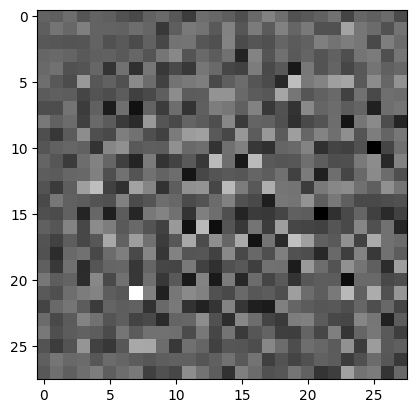

In [ ]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
print("The first output of generator (1st step)")
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

In [ ]:
decision = discriminator(generated_image)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
@tf.function
def train_step(images, batch_size):

    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([batch_size, noise_dim])

    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using
    # operations recorded in context of this tape (gen_tape and disc_tape).

    # It accepts a target (e.g., gen_loss) variable and
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors
    # (or IndexedSlices, or None), one for each element in sources.
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss,
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients.
    # ex: optimizer.apply_gradients(zip(grads, vars))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs, batch_size):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch,
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch, batch_size)
  print("minimax loss obtained")
  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)

In [ ]:
def generate_and_save_images(model, test_input, epoch, batch_size, input_index):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(4,4))
  path_to_save = "/content/gdrive/MyDrive/Machine Learning Course Projects"
  for i in range(predictions.shape[0]):
      plt.imshow(predictions[i, :, :, 0] * 200 + 200, cmap='gray')
      plt.axis('off')
      image_name = path_to_save + '/'+str(epoch)+"_"+str(batch_size)+"_label_"+str(i)+"_"+ str(input_index) +".png"
      plt.savefig(image_name)

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 200 + 200, cmap='gray')
      plt.axis('off')
  plt.show()

In [ ]:
BATCH_SIZE = 100
BUFFER_SIZE = 60000
EPOCHS = 30
num_examples_to_generate = 16
noise_dim = 100

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
random_noise1 = tf.random.normal([num_examples_to_generate, noise_dim])
random_noise2 = tf.random.normal([num_examples_to_generate, noise_dim])
random_noise3 = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
train(train_dataset, BATCH_SIZE, EPOCHS)

minimax loss obtained


Outputs for  30  number of epochs and  100  batch size


<ipython-input-56-7108923a2151>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, i+1)


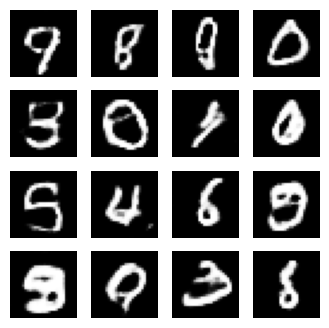

In [ ]:
print("Outputs for ", EPOCHS , " number of epochs and " , BATCH_SIZE, " batch size")
generate_and_save_images(generator, random_noise1, EPOCHS, BATCH_SIZE, 1)

Outputs for  30  number of epochs and  100  batch size


<ipython-input-56-7108923a2151>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, i+1)


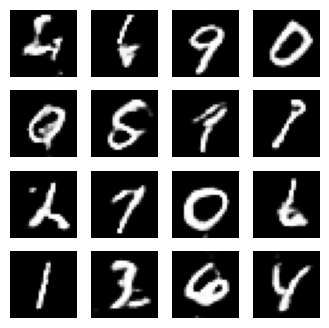

In [ ]:
print("Outputs for ", EPOCHS , " number of epochs and " , BATCH_SIZE, " batch size")
generate_and_save_images(generator, random_noise2, EPOCHS, BATCH_SIZE, 2)

Outputs for  30  number of epochs and  100  batch size


<ipython-input-56-7108923a2151>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, i+1)


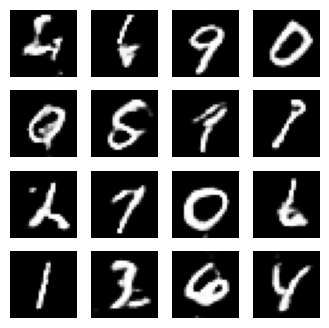

In [ ]:
print("Outputs for ", EPOCHS , " number of epochs and " , BATCH_SIZE, " batch size")
generate_and_save_images(generator, random_noise2, EPOCHS, BATCH_SIZE, 3)

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 60000
EPOCHS = 60

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train(train_dataset, BATCH_SIZE, EPOCHS)

Outputs for  30  number of epochs and  50  batch size


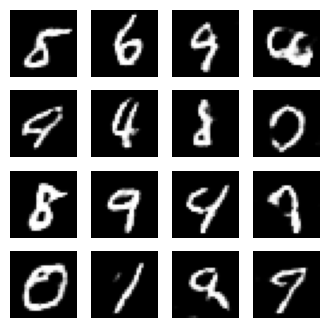

In [ ]:
print("Outputs for ", EPOCHS , " number of epochs and " , BATCH_SIZE, " batch size")
generate_and_save_images(generator, random_noise1)

Outputs for  30  number of epochs and  50  batch size


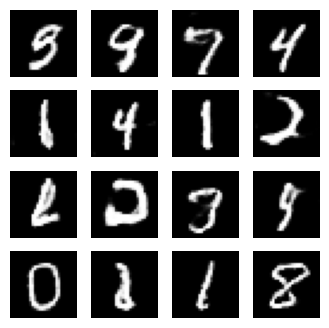

In [ ]:
print("Outputs for ", EPOCHS , " number of epochs and " , BATCH_SIZE, " batch size")
generate_and_save_images(generator, random_noise2)

Outputs for  30  number of epochs and  50  batch size


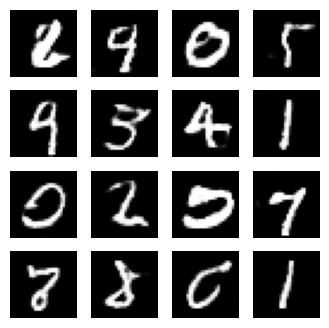

In [ ]:
print("Outputs for ", EPOCHS , " number of epochs and " , BATCH_SIZE, " batch size")
generate_and_save_images(generator, random_noise3)